In [187]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (10, 5)

In [139]:
from gensim.corpora import Dictionary

config = {
    "inputData": "/home/jvdzwaan/data/dilipad/CAP/vragenuurtje/*",
    "outDir": "/home/jvdzwaan/data/dilipad/results/all_years-adj-cabinets_selected-parties/{}",
    "nTopics": 100
}

# topic dict inlezen
topicDict = Dictionary.load(config.get('outDir').format('topicDict.dict'))
print topicDict

Dictionary(38145 unique tokens: [u'baangarantie', u'ontwerprichtlijn', u'scheuring', u'cli\xebntniveau', u'leveringsakte']...)


In [140]:
import glob
import re
import os
import codecs
import gensim

# corpus maken
text_files = glob.glob(config.get('inputData'))
#print len(text_files)

text_ids = [int(re.search(r'\d+', f).group()) for f in text_files]
text_ids.sort()
#print text_ids

texts = []
for text_id in text_ids:
    if text_id != 1351: # text without main code
        with codecs.open("/home/jvdzwaan/data/dilipad/CAP/vragenuurtje/{}.txt".format(text_id), 'rb', encoding='utf-8') as f:
            lines = f.readlines()
        nouns = lines[0].split()
        #filtered = [n for n in nouns if n in topicDict.values()]
        #with codecs.open("/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_filtered/{}.txt".format(text_id), 'wb', encoding='utf-8') as f:
        #    f.write(' '.join(filtered))
        texts.append(nouns)
        #print nouns

# gensim.matutils.corpus2dense als input voor sklearn -> doe ik niet meer
#corpus = [topicDict.doc2bow(text) for text in texts]
#print corpus
#corpus_dense = gensim.matutils.corpus2dense(corpus, len(topicDict), num_docs=len(texts))
#print corpus_dense.shape

In [141]:
#print topicDict.values()

In [142]:
# get class labels
data = pd.read_excel('/home/jvdzwaan/data/dilipad/CAP/PA OQ COMPLETE.xls', index_col=0)
data['main code'] = data.apply(lambda row: int(row['subcode']) / 100, axis=1)
print text_ids[0], text_ids[-1]
data = data.loc[text_ids]
class_labels = data[data['main code'] != 0]['main code'].values

#print class_labels
print len(class_labels)

672 1507
834


In [143]:
def split(s):
    return s.split()

filtered_texts = []
for text_id in text_ids:
    if text_id != 1351: # text without main code
        with codecs.open("/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_filtered/{}.txt".format(text_id), 'rb', encoding='utf-8') as f:
            filtered_texts.append(f.read())
print len(filtered_texts)
#print text_ids

834


In [144]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, precision_score, recall_score

performance = pd.DataFrame(np.zeros((5, 4)), columns=['accuracy', 'precision', 'recall', 'F1'], index=range(5))

skf = StratifiedKFold(class_labels, 5, random_state=345)
for it, (train, test) in enumerate(skf):
    train_X = [filtered_texts[i] for i in train]
    train_Y = [class_labels[i] for i in train]
    test_X = [filtered_texts[i] for i in test]
    test_Y = [class_labels[i] for i in test]
    
    clf = make_pipeline(TfidfVectorizer(analyzer=split),
                       MultinomialNB())
    clf.fit(train_X, train_Y)

    pred = clf.predict(test_X)
    #print len(pred), len(class_labels[test])
    
    #print class_labels[test]
    #print pred
    performance.loc[it, 'accuracy'] = accuracy_score(test_Y, pred)
    performance.loc[it, 'precision'] = precision_score(test_Y, pred, average='weighted')
    performance.loc[it, 'recall'] = recall_score(test_Y, pred, average='weighted')
    performance.loc[it, 'F1'] = f1_score(test_Y, pred, average='weighted')
    
performance.to_csv('/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_performance_nb.csv', encoding='utf-8')
performance

,accuracy,precision,recall,F1
0,0.445087,0.413674,0.445087,0.362879
1,0.415205,0.368686,0.415205,0.344547
2,0.488095,0.480417,0.488095,0.418525
3,0.463415,0.485890,0.463415,0.401963
4,0.424051,0.453595,0.424051,0.357244


In [145]:
from sklearn.svm import LinearSVC

performance = pd.DataFrame(np.zeros((5, 4)), columns=['accuracy', 'precision', 'recall', 'F1'], index=range(5))

skf = StratifiedKFold(class_labels, 5, random_state=345)
for it, (train, test) in enumerate(skf):
    train_X = [filtered_texts[i] for i in train]
    train_Y = [class_labels[i] for i in train]
    test_X = [filtered_texts[i] for i in test]
    test_Y = [class_labels[i] for i in test]
    
    clf = make_pipeline(TfidfVectorizer(analyzer=split),
                        LinearSVC(class_weight='auto'))
    clf.fit(train_X, train_Y)

    pred = clf.predict(test_X)
    #print len(pred), len(class_labels[test])
    
    #print class_labels[test]
    #print pred
    
    performance.loc[it, 'accuracy'] = accuracy_score(test_Y, pred)
    performance.loc[it, 'precision'] = precision_score(test_Y, pred, average='weighted')
    performance.loc[it, 'recall'] = recall_score(test_Y, pred, average='weighted')
    performance.loc[it, 'F1'] = f1_score(test_Y, pred, average='weighted')
    
performance.to_csv('/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_performance_svm.csv', encoding='utf-8')
performance

,accuracy,precision,recall,F1
0,0.595376,0.563234,0.595376,0.558710
1,0.602339,0.616954,0.602339,0.591722
2,0.630952,0.596047,0.630952,0.598463
3,0.634146,0.680253,0.634146,0.634989
4,0.550633,0.551798,0.550633,0.542064


In [146]:
from sklearn.externals import joblib

#clf = make_pipeline(TfidfVectorizer(analyzer=split),
#                        LinearSVC(class_weight='auto'))
#clf.fit(filtered_texts, class_labels)

#joblib.dump(clf, '/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_classifier/classifier.pkl')

clf = joblib.load('/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_classifier/classifier.pkl')

In [147]:
usefulness_data = pd.read_csv(config.get('outDir').format('topics_100_data.csv'), index_col=0, encoding='utf-8')
#usefulness_data

In [148]:
# predict CAP categories for top 10 topic words

res = clf.predict(usefulness_data['words'])
print res

[19  3 19 16 10  3 10  3 15 15 19 15  6 15 16 20 12 12 19 17 14  3  5  3 12
  5  4 20 19 15  6 19  2  2 13 19 15  4  1 14  2 13 15 19  1  2  7 15  1  6
 19 19 15 14 13 12  4  2  3  5 20 17  2  2 20 19  6  8  8 16 19 13 19 20 12
 13 12 15  8 16  6  3  2  3 10  7 20 10 19 21 12 17 12 20  3 12  6  1  2 13]


In [149]:
# add predicted cap categories to usefulness data
usefulness_data['cap_svm'] = res
usefulness_data.to_csv(config.get('outDir').format('topics_100_data.csv'), encoding='utf-8')
#usefulness_data

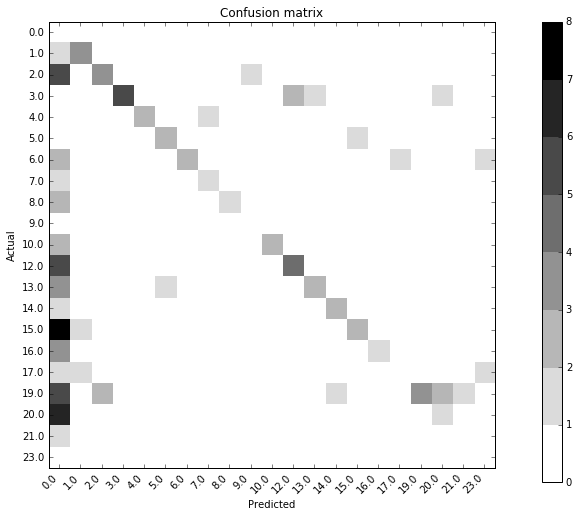

In [150]:
# confusion matrix voor handmatige cap categorien voor top 10 topic woorden vs. automatisch voorspelde
# Accuracy: 0.36
from pandas_confusion import ConfusionMatrix
cm = ConfusionMatrix(usefulness_data['cap_svm'], usefulness_data['cap'].fillna(0))
#cm.print_stats()
#print cm
cm.plot()

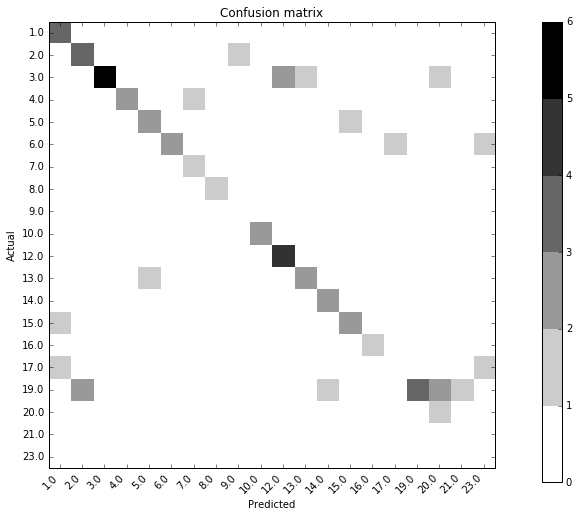

In [151]:
# confusion matrix voor handmatige cap categorien voor top 10 topic woorden zonder 
# low quality topics vs. automatisch voorspelde
# Accuracy: 0.654545454545
known = usefulness_data.dropna()
#known
cm = ConfusionMatrix(known['cap_svm'], known['cap'])
#cm.print_stats()
#print cm
cm.plot()

In [152]:
topic2cap = dict(usefulness_data['cap_svm'])
print topic2cap

{0: 19, 1: 3, 2: 19, 3: 16, 4: 10, 5: 3, 6: 10, 7: 3, 8: 15, 9: 15, 10: 19, 11: 15, 12: 6, 13: 15, 14: 16, 15: 20, 16: 12, 17: 12, 18: 19, 19: 17, 20: 14, 21: 3, 22: 5, 23: 3, 24: 12, 25: 5, 26: 4, 27: 20, 28: 19, 29: 15, 30: 6, 31: 19, 32: 2, 33: 2, 34: 13, 35: 19, 36: 15, 37: 4, 38: 1, 39: 14, 40: 2, 41: 13, 42: 15, 43: 19, 44: 1, 45: 2, 46: 7, 47: 15, 48: 1, 49: 6, 50: 19, 51: 19, 52: 15, 53: 14, 54: 13, 55: 12, 56: 4, 57: 2, 58: 3, 59: 5, 60: 20, 61: 17, 62: 2, 63: 2, 64: 20, 65: 19, 66: 6, 67: 8, 68: 8, 69: 16, 70: 19, 71: 13, 72: 19, 73: 20, 74: 12, 75: 13, 76: 12, 77: 15, 78: 8, 79: 16, 80: 6, 81: 3, 82: 2, 83: 3, 84: 10, 85: 7, 86: 20, 87: 10, 88: 19, 89: 21, 90: 12, 91: 17, 92: 12, 93: 20, 94: 3, 95: 12, 96: 6, 97: 1, 98: 2, 99: 13}


In [153]:
def top10(row, n=10):
    #print list(row.sort_values(ascending=False).index[:10])
    return pd.Series(list(row.sort_values(ascending=False).index[:n]))

In [181]:
# Are all CAP categories present in the topics?
from collections import Counter

c = Counter()
d = {}
for topic, cap in topic2cap.iteritems():
    c[cap] += 1
    if not cap in d.keys():
        d[cap] = []
    d[cap].append(topic)
print c.keys()

manual = Counter()
for l in class_labels:
    manual[l] += 1

print manual.keys()

[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21]
[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21]


In [182]:
topic_cap_mapping = pd.concat([pd.Series(manual), pd.Series(d), pd.Series(c)], axis=1)
topic_cap_mapping.columns = ['number of texts', 'topics numbers', 'number of topics']

In [183]:
# manually selected high quality topics
c = Counter()
hq = {}
for i, h in enumerate(usefulness_data['mean_usefulness'] > 2.0):
    if h:
        cap = topic2cap[i]
        c[cap] += 1
        if not cap in hq.keys():
            hq[cap] = []
        hq[cap].append(i)
print hq.keys()

hq[21] = []
c[21] = 0

topic_cap_mapping['high quality topics'] = pd.Series(hq)
topic_cap_mapping['number of high quality topics'] = pd.Series(c)
topic_cap_mapping['percentage of texts'] = topic_cap_mapping.apply(lambda row: float(row['number of texts'])/np.sum(topic_cap_mapping['number of texts']) * 100.0, axis=1)
topic_cap_mapping

[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20]


,number of texts,topics numbers,number of topics,high quality topics,number of high quality topics,percentage of texts
1,28,"[38, 44, 48, 97]",4,"[38, 44, 97]",3,3.357314
2,72,"[32, 33, 40, 45, 57, 62, 63, 82, 98]",9,"[32, 33, 40, 98]",4,8.633094
3,88,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9,10.551559
4,24,"[26, 37, 56]",3,"[26, 37, 56]",3,2.877698
5,79,"[22, 25, 59]",3,"[22, 25, 59]",3,9.472422
6,67,"[12, 30, 49, 66, 80, 96]",6,"[30, 49, 66, 96]",4,8.033573
7,20,"[46, 85]",2,[46],1,2.398082
8,21,"[67, 68, 78]",3,[78],1,2.517986
10,46,"[4, 6, 84, 87]",4,"[4, 87]",2,5.515588
12,108,"[16, 17, 24, 55, 74, 76, 90, 92, 95]",9,"[17, 24, 55, 76, 92, 95]",6,12.949640


In [184]:
# automatically selected high quality topics
print usefulness_data['npmi'].mean()
c = Counter()
hq = {}
for i, h in enumerate(usefulness_data['npmi'] > usefulness_data['npmi'].mean()):
    if h:
        cap = topic2cap[i]
        c[cap] += 1
        if not cap in hq.keys():
            hq[cap] = []
        hq[cap].append(i)
print hq.keys()

hq[21] = []
c[21] = 0

topic_cap_mapping['npmi high quality topics'] = pd.Series(hq)
topic_cap_mapping['number of npmi high quality topics'] = pd.Series(c)
topic_cap_mapping

-0.1943359
[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20]


,number of texts,topics numbers,number of topics,high quality topics,number of high quality topics,percentage of texts,npmi high quality topics,number of npmi high quality topics
1,28,"[38, 44, 48, 97]",4,"[38, 44, 97]",3,3.357314,[97],1
2,72,"[32, 33, 40, 45, 57, 62, 63, 82, 98]",9,"[32, 33, 40, 98]",4,8.633094,"[32, 40, 45, 62, 63, 98]",6
3,88,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9,10.551559,"[7, 21, 81]",3
4,24,"[26, 37, 56]",3,"[26, 37, 56]",3,2.877698,"[26, 37, 56]",3
5,79,"[22, 25, 59]",3,"[22, 25, 59]",3,9.472422,[25],1
6,67,"[12, 30, 49, 66, 80, 96]",6,"[30, 49, 66, 96]",4,8.033573,"[49, 96]",2
7,20,"[46, 85]",2,[46],1,2.398082,[46],1
8,21,"[67, 68, 78]",3,[78],1,2.517986,[78],1
10,46,"[4, 6, 84, 87]",4,"[4, 87]",2,5.515588,"[4, 87]",2
12,108,"[16, 17, 24, 55, 74, 76, 90, 92, 95]",9,"[17, 24, 55, 76, 92, 95]",6,12.949640,"[17, 24, 76]",3


In [157]:
import glob

d = pd.read_csv('/home/jvdzwaan/data/dilipad/CAP/parties_through_time_vragenuurtje_results/theta_100_0.csv', index_col=0)
res = pd.DataFrame(index=d.index)

files = glob.glob('/home/jvdzwaan/data/dilipad/CAP/parties_through_time_vragenuurtje_results/*_*_*.csv')
#print files
for i, fi in enumerate(files):
    df = pd.read_csv(fi, index_col=0)
    res[i] = df.apply(lambda row: top10(row, 1), axis=1)
#print topic2cap
res[['cap{}'.format(i) for i in range(10)]] = res.apply(lambda series: [topic2cap[int(v)] for v in series])
res

,0,1,2,3,4,5,6,7,8,9,cap0,cap1,cap2,cap3,cap4,cap5,cap6,cap7,cap8,cap9
1000.txt,83,83,83,83,83,83,83,83,83,83,3,3,3,3,3,3,3,3,3,3
1001.txt,87,87,87,87,87,87,87,87,87,87,10,10,10,10,10,10,10,10,10,10
1002.txt,58,58,58,58,58,58,58,58,58,58,3,3,3,3,3,3,3,3,3,3
1003.txt,71,71,71,71,71,71,71,5,71,71,13,13,13,13,13,13,13,3,13,13
1004.txt,26,26,26,26,26,26,26,26,26,26,4,4,4,4,4,4,4,4,4,4
1005.txt,87,87,87,87,87,87,87,87,87,87,10,10,10,10,10,10,10,10,10,10
1006.txt,97,53,97,97,97,97,97,23,97,53,1,14,1,1,1,1,1,3,1,14
1007.txt,21,21,21,21,21,21,21,21,21,21,3,3,3,3,3,3,3,3,3,3
1008.txt,25,25,25,25,25,25,25,25,25,25,5,5,5,5,5,5,5,5,5,5
1009.txt,61,61,61,61,61,61,61,61,61,61,17,17,17,17,17,17,17,17,17,17


In [158]:
# performance uitrekenen
import re

text_files = glob.glob('/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_filtered/*')
text_files.sort()
#print text_files
print len(text_files)

text_ids = [int(re.search(r'\d+', f).group()) for f in text_files]

data = pd.read_excel('/home/jvdzwaan/data/dilipad/CAP/PA OQ COMPLETE.xls', index_col=0)
data['main code'] = data.apply(lambda row: int(row['subcode']) / 100, axis=1)
data = data.loc[text_ids]
class_labels = data[data['main code'] != 0]['main code'].values

#print class_labels
#print len(class_labels)

834


In [159]:
performance = pd.DataFrame(np.zeros((5, 4)), columns=['accuracy', 'precision', 'recall', 'F1'], index=range(5))

res = res.loc[[f.replace('/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_filtered/', '') for f in text_files]]

for it in range(10):
    performance.loc[it, 'accuracy'] = accuracy_score(class_labels, res['cap{}'.format(it)])
    performance.loc[it, 'precision'] = precision_score(class_labels, res['cap{}'.format(it)], average='weighted')
    performance.loc[it, 'recall'] = recall_score(class_labels, res['cap{}'.format(it)], average='weighted')
    performance.loc[it, 'F1'] = f1_score(class_labels, res['cap{}'.format(it)], average='weighted')
    
performance.to_csv('/home/jvdzwaan/data/dilipad/CAP/parties_through_time_vragenuurtje_results/performance_tm.csv', encoding='utf-8')
performance

,accuracy,precision,recall,F1
0,0.543165,0.547276,0.543165,0.538286
1,0.544365,0.552280,0.544365,0.541498
2,0.564748,0.575050,0.564748,0.564693
3,0.549161,0.554472,0.549161,0.545648
4,0.562350,0.567914,0.562350,0.561040
5,0.547962,0.551110,0.547962,0.543994
6,0.551559,0.565014,0.551559,0.552339
7,0.551559,0.560251,0.551559,0.551534
8,0.540767,0.551877,0.540767,0.540574
9,0.545564,0.553517,0.545564,0.543563


In [160]:
res

,0,1,2,3,4,5,6,7,8,9,cap0,cap1,cap2,cap3,cap4,cap5,cap6,cap7,cap8,cap9
1000.txt,83,83,83,83,83,83,83,83,83,83,3,3,3,3,3,3,3,3,3,3
1001.txt,87,87,87,87,87,87,87,87,87,87,10,10,10,10,10,10,10,10,10,10
1002.txt,58,58,58,58,58,58,58,58,58,58,3,3,3,3,3,3,3,3,3,3
1003.txt,71,71,71,71,71,71,71,5,71,71,13,13,13,13,13,13,13,3,13,13
1004.txt,26,26,26,26,26,26,26,26,26,26,4,4,4,4,4,4,4,4,4,4
1005.txt,87,87,87,87,87,87,87,87,87,87,10,10,10,10,10,10,10,10,10,10
1006.txt,97,53,97,97,97,97,97,23,97,53,1,14,1,1,1,1,1,3,1,14
1007.txt,21,21,21,21,21,21,21,21,21,21,3,3,3,3,3,3,3,3,3,3
1008.txt,25,25,25,25,25,25,25,25,25,25,5,5,5,5,5,5,5,5,5,5
1009.txt,61,61,61,61,61,61,61,61,61,61,17,17,17,17,17,17,17,17,17,17


In [161]:
counts_data = {}
for i in range(10):
    cap = 'cap{}'.format(i)
    counts = res[cap].value_counts()
    counts_data[cap] = counts

c = pd.DataFrame(counts_data)
c['mean'] = c.apply(lambda row: np.mean(row), axis=1)
c['std'] = c.apply(lambda row: np.std(row), axis=1)
c

,cap0,cap1,cap2,cap3,cap4,cap5,cap6,cap7,cap8,cap9,mean,std
1,45,44,43,46,45,36,43,41,38,42,42.3,2.893567
2,99,94,86,91,97,95,95,84,104,84,92.9,6.006814
3,82,81,77,85,80,81,78,86,79,87,81.6,3.080732
4,38,33,37,38,28,42,31,39,33,38,35.7,3.862406
5,57,58,63,61,66,66,60,66,60,55,61.2,3.587858
6,64,70,62,66,64,67,60,61,61,61,63.6,2.929474
7,16,18,14,12,18,18,24,14,20,16,17.0,3.104249
8,23,23,19,29,22,22,21,20,22,22,22.3,2.413974
10,55,53,48,55,50,51,48,49,49,45,50.3,2.924815
12,85,91,100,90,90,92,100,95,87,103,93.3,5.428042


In [185]:
topic_cap_mapping['mean number texts predicted'] = c['mean']
topic_cap_mapping['std number texts predicted'] = c['std']
topic_cap_mapping = topic_cap_mapping.fillna(0)
topic_cap_mapping

,number of texts,topics numbers,number of topics,high quality topics,number of high quality topics,percentage of texts,npmi high quality topics,number of npmi high quality topics,mean number texts predicted,std number texts predicted
1,28,"[38, 44, 48, 97]",4,"[38, 44, 97]",3,3.357314,[97],1,0,0
2,72,"[32, 33, 40, 45, 57, 62, 63, 82, 98]",9,"[32, 33, 40, 98]",4,8.633094,"[32, 40, 45, 62, 63, 98]",6,0,0
3,88,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9,10.551559,"[7, 21, 81]",3,0,0
4,24,"[26, 37, 56]",3,"[26, 37, 56]",3,2.877698,"[26, 37, 56]",3,0,0
5,79,"[22, 25, 59]",3,"[22, 25, 59]",3,9.472422,[25],1,0,0
6,67,"[12, 30, 49, 66, 80, 96]",6,"[30, 49, 66, 96]",4,8.033573,"[49, 96]",2,0,0
7,20,"[46, 85]",2,[46],1,2.398082,[46],1,0,0
8,21,"[67, 68, 78]",3,[78],1,2.517986,[78],1,0,0
10,46,"[4, 6, 84, 87]",4,"[4, 87]",2,5.515588,"[4, 87]",2,0,0
12,108,"[16, 17, 24, 55, 74, 76, 90, 92, 95]",9,"[17, 24, 55, 76, 92, 95]",6,12.949640,"[17, 24, 76]",3,0,0


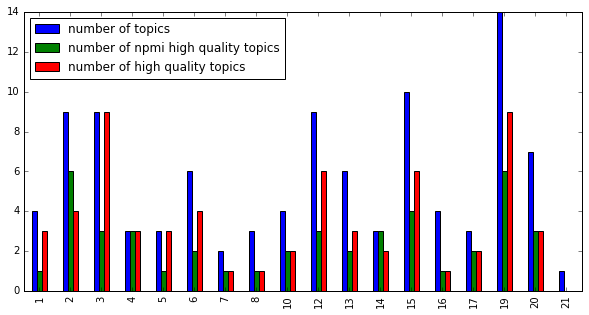

In [189]:
topic_cap_mapping[['number of topics', 'number of npmi high quality topics', 'number of high quality topics']].plot(kind='bar')

In [194]:
print np.round(topic_cap_mapping[['percentage of texts']], decimals=2).to_latex()
topic_cap_mapping[['percentage of texts']]

\begin{tabular}{lr}
\toprule
{} &  percentage of texts \\
\midrule
1  &                 3.36 \\
2  &                 8.63 \\
3  &                10.55 \\
4  &                 2.88 \\
5  &                 9.47 \\
6  &                 8.03 \\
7  &                 2.40 \\
8  &                 2.52 \\
10 &                 5.52 \\
12 &                12.95 \\
13 &                 7.19 \\
14 &                 4.08 \\
15 &                 3.48 \\
16 &                 3.36 \\
17 &                 1.68 \\
19 &                 7.67 \\
20 &                 5.64 \\
21 &                 0.60 \\
\bottomrule
\end{tabular}



,percentage of texts
1,3.357314
2,8.633094
3,10.551559
4,2.877698
5,9.472422
6,8.033573
7,2.398082
8,2.517986
10,5.515588
12,12.949640
